In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from alive_progress import alive_bar

from scipy.interpolate import interp1d

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
plt_colors = [
    "tab:blue",
    "tab:orange",
    "plum",
    "orangered",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

2023-06-01 12:23:00.875705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 12:23:01.752633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-01 12:23:01.752699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-01 12:23:01.752706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  1


2023-06-01 12:23:02.320780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 12:23:02.349323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 12:23:02.349667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Loading the data
TELEM_PATH = r"../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(
    TELEM_PATH,
    "telem",
)

# Adding illumination data:
for i, row in telem_df.iterrows():
    telem_df.loc[i, "illumination"] = 1 if row["theta_T (deg)"] < 360 * (1 - row["fe"]) else 0

# Reordering columns to have illumination after theta_T (deg):
illum_col = telem_df["illumination"].to_numpy()
telem_df = telem_df.drop("illumination", axis=1)
telem_df.insert(loc=6, column="illumination", value=illum_col)

telem_df.head()

,time (utc),time (jd),beta (deg),fe,theta (deg),theta_T (deg),illumination,black chassis temperature (deg C),silver chassis temperature (deg C),black panel temperature (deg C),silver panel temperature (deg C),solar panel +X temperature (deg C),solar panel -X temperature (deg C),solar panel +Y temperature (deg C),solar panel -Y temperature (deg C)
0,2016-02-04 00:00:00.000,2.457422e+06,43.419578,0.314142,287.512192,50.966681,1.0,1.23,-0.85,-2.10,2.23,3.39,-2.41,-1.40,0.43
1,2016-02-04 00:01:00.000,2.457423e+06,43.419238,0.313883,291.258857,54.759942,1.0,1.47,1.17,2.75,5.04,0.69,0.92,2.75,-2.91
2,2016-02-04 00:02:00.000,2.457423e+06,43.418972,0.313594,295.003917,58.556932,1.0,0.00,2.44,7.00,8.09,-1.80,3.84,-0.57,1.89
3,2016-02-04 00:03:00.000,2.457423e+06,43.418786,0.313277,298.747190,62.357285,1.0,1.68,1.81,4.38,5.67,2.97,0.50,-1.40,3.77
4,2016-02-04 00:04:00.000,2.457423e+06,43.418684,0.312933,302.488507,66.160507,1.0,3.65,2.77,6.23,6.31,2.14,0.50,3.79,0.22


In [3]:
def normalize_datasets(df, min_temp, max_temp):
    df = df.copy()
    df.iloc[:, 7:] = (
        df.iloc[:, 7:] - min_temp
    ) / (max_temp - min_temp)

    return df

def window_data(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna().reset_index(drop=True)

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), window_size, 1), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[1:window_size + 1]
            y_data[i, :] = row.iloc[window_size + 1:]

        return window_df, x_data, y_data

    return window_df

In [4]:
# Processing the data to remove constant rows and adding illumination data:
telem_processed_df = telem_df.copy()
prev_row = telem_processed_df.loc[0]

for i, row in telem_processed_df.iterrows():
    if i == 0:
        continue
    # Check for same temperature values
    if row.loc[
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
    ].equals(
        prev_row.loc[
            "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
        ]
    ):
        telem_processed_df.drop(i, inplace=True)
        continue
    # Check for same time
    if (
        row.loc["time (utc)"]
        == prev_row.loc["time (utc)"]
    ):
        telem_processed_df.drop(i, inplace=True)
        continue

    prev_row = row

telem_processed_df = (
    telem_processed_df.reset_index(drop=True)
)

In [5]:
# Splitting the data into training and testing sets
train_df = telem_processed_df[:int(0.8 * len(telem_processed_df))].copy()
test_df = telem_processed_df[int(0.8 * len(telem_processed_df)):].copy().reset_index(drop=True)

# Normalizing the data
min_temp = train_df.iloc[:, 7:].min().min()
max_temp = train_df.iloc[:, 7:].max().max()

train_norm_df = normalize_datasets(train_df, min_temp, max_temp)
test_norm_df = normalize_datasets(test_df, min_temp, max_temp)

In [6]:
train_50_df, x_train_50, y_train_50 = window_data(train_norm_df, 50, return_numpy=True)
test_50_df, x_test_50, y_test_50 = window_data(test_norm_df, 50, return_numpy=True)

In [7]:
def create_model(layers, optimizer, loss_function, metric_function, input_shape=(None, 1), output_shape=4):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    recommended_device = "/GPU:0"
    for i, layer in enumerate(layers):
        if layer.get("type") == "LSTM":
            if i < len(layers) - 1:
                if layers[i + 1].get("type") == "LSTM":
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=True,
                        )
                    )
                else:
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
            else:
                model.add(
                    tf.keras.layers.LSTM(
                        layer.get("units"),
                        activation=layer.get("activation"),
                        return_sequences=False,
                    )
                )
            if layer.get("activation") == "relu":
                recommended_device = "/CPU:0"
        elif layer.get("type") == "Dense":
            model.add(
                tf.keras.layers.Dense(
                    layer.get("units"), activation=layer.get("activation"),
                )
            )
        else:
            raise ValueError("Invalid layer type")
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[metric_function],
    )
    return model, recommended_device

In [8]:
model_50_layers = np.empty(shape=(7), dtype=dict,)
model_50_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_50_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_50_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_50_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_50_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_50_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_50_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_50, recommended_device = create_model(
    model_50_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_50.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_50 = model_50.fit(
        x_train_50,
        y_train_50,
        epochs=200,
        validation_data=(x_test_50, y_test_50),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_50.history["loss"]), len(history_50.history["loss"])),
    history_50.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_50.history["loss"]), len(history_50.history["loss"])),
    history_50.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

2023-06-01 12:23:15.015082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 12:23:15.015879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 12:23:15.016189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 12:23:15.016334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

2023-06-01 12:23:23.748907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-06-01 12:23:23.748949: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at cudnn_rnn_ops.cc:1554 : UNKNOWN: Fail to find the dnn implementation.


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_16055]

In [8]:
def plot_model(theta_T_vals, y_data, y_single_pred=None, y_auto_pred=None, plt_title=None, limit_axis=True):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(
        theta_T_vals,
        y_data[:, 0],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 0],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 0],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Black chassis")

    plt.subplot(2, 2, 2)
    plt.plot(
        theta_T_vals,
        y_data[:, 1],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 1],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 1],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Silver chassis")

    plt.subplot(2, 2, 3)
    plt.plot(
        theta_T_vals,
        y_data[:, 2],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 2],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 2],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Black panel")

    plt.subplot(2, 2, 4)
    plt.plot(
        theta_T_vals,
        y_data[:, 3],
        label="Data",
        color=plt_colors[0],
    )
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 3],
            label="Single-step prediction",
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 3],
            label="Auto-regressive prediction",
            color=plt_colors[2],
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Silver panel")

    if plt_title is not None:
        plt.suptitle(plt_title)
    plt.show()
    plt.close()

In [9]:
def test_model(model, x_data, single_step_pred=False, auto_regressive_pred=False):
    if single_step_pred:
        y_single_pred = model.predict(x_data, verbose=False)
    else:
        y_single_pred = None

    if auto_regressive_pred:
        x_auto_pred = np.empty(shape=x_data.shape, dtype=np.float64)
        y_auto_pred = np.empty(shape=(x_data.shape[0], 4), dtype=np.float64)

        x_auto_pred[0] = x_data[0]
        with alive_bar(total=x_data.shape[0], theme="classic", force_tty=True, title="Predicting") as bar:
            for i, x in enumerate(x_auto_pred):
                y_auto_pred[i] = model.predict(x.reshape(1, x_auto_pred.shape[1], x_auto_pred.shape[2]), verbose=False)
                if i < x_data.shape[0]-1:
                    x_auto_pred[i+1] = np.concatenate((x[1:], y_auto_pred[i].reshape(1, 4)), axis=0)
                bar()
    else:
        y_auto_pred = None

    return y_single_pred, y_auto_pred

In [10]:
# Orbit with known anomaly:
anomaly_df = telem_df.loc[374:571].copy().reset_index(drop=True)

# Normalizing data:
anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] = (
    anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] - min_temp
) / (max_temp - min_temp)

# Remove duplicate theta_T values:
anomaly_df = anomaly_df.drop_duplicates(subset="theta_T (deg)", keep="last").reset_index(drop=True)

In [11]:
def create_artificial_anomaly(window_size, anomaly_black_chassis=False, anomaly_silver_chassis=False, anomaly_black_panel=False, anomaly_silver_panel=False):
    artificial_anomaly_df = pd.DataFrame(
        columns=[
            "theta_T (deg)",
            "illumination",
            "black chassis temperature (deg C)",
            "silver chassis temperature (deg C)",
            "black panel temperature (deg C)",
            "silver panel temperature (deg C)",
        ],
    )
    if window_size < 94:
        orbit_0_end = 94
        orbit_0_start = orbit_0_end - window_size
        orbit_1_start = 94
        orbit_1_end = 191
    else:
        orbit_0_end = 94 + (window_size - 94)
        orbit_0_start = 0
        orbit_1_start = 94 + (window_size - 94)
        orbit_1_end = 191 + (window_size - 94)
    anomaly_df_temp_0 = anomaly_df[100-window_size:99].copy().reset_index(drop=True)
    anomaly_df_temp_1 = anomaly_df[100:].copy().reset_index(drop=True)
    
    artificial_anomaly_df["theta_T (deg)"] = test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end]
    artificial_anomaly_df["illumination"] = test_norm_df["illumination"][orbit_0_start:orbit_0_end]
    # One orbit before anomaly:
    if anomaly_black_chassis:
        black_chassis_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["black chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["black chassis temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )
    
    if anomaly_silver_chassis:
        silver_chassis_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["silver chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["silver chassis temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_black_panel:
        black_panel_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["black panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["black panel temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_panel:
        silver_panel_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["silver panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["silver panel temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )


    artificial_anomaly_df["black chassis temperature (deg C)"] = black_chassis_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["silver chassis temperature (deg C)"] = silver_chassis_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["black panel temperature (deg C)"] = black_panel_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["silver panel temperature (deg C)"] = silver_panel_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )

    # Anomaly orbit:
    if anomaly_black_chassis:
        black_chassis_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["black chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["black chassis temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_chassis:
        silver_chassis_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["silver chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["silver chassis temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_black_panel:
        black_panel_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["black panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["black panel temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_panel:
        silver_panel_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["silver panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["silver panel temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    artificial_anomaly_df = artificial_anomaly_df.reset_index(drop=True)

    theta_T_anomaly_orbit = test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end].to_numpy()
    illumination_anomaly_orbit = test_norm_df["illumination"][orbit_1_start:orbit_1_end].to_numpy()
    for i in range(len(theta_T_anomaly_orbit)):
        artificial_anomaly_df.loc[window_size + i, "theta_T (deg)"] = theta_T_anomaly_orbit[i]
        artificial_anomaly_df.loc[window_size + i, "illumination"] = illumination_anomaly_orbit[i]
        artificial_anomaly_df.loc[window_size + i, "black chassis temperature (deg C)"] = black_chassis_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "silver chassis temperature (deg C)"] = silver_chassis_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "black panel temperature (deg C)"] = black_panel_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "silver panel temperature (deg C)"] = silver_panel_interp(
            theta_T_anomaly_orbit[i]
        )   

    return artificial_anomaly_df

In [41]:
anomaly_df_temp_0 = anomaly_df[100-97:99].copy().reset_index(drop=True)
x = anomaly_df_temp_0["theta_T (deg)"].to_numpy()

# check for duplicate values
print(np.unique(x, return_counts=True))

(array([  5.23553273,   8.95446942,  12.6807786 ,  16.41422757,
        20.15494701,  23.90256057,  27.65700053,  31.41804695,
        35.18525752,  38.95855208,  42.7373444 ,  46.52137593,
        50.3102465 ,  54.10333107,  57.90039533,  61.70071713,
        65.50390949,  69.30946142,  73.11667421,  76.92524152,
        80.73439186,  84.54371564,  88.35269677,  92.1606487 ,
        95.96728847,  99.77190414, 103.57414461, 107.37357016,
       111.16959516, 114.96204044, 118.75030847, 122.53417568,
       126.31333722, 130.0873469 , 133.85616742, 137.61935646,
       141.37683567, 145.12844905, 148.87391328, 152.61332998,
       156.34641263, 160.07322576, 163.79375684, 167.50786008,
       171.21576209, 174.91731429, 178.61269274, 182.30200179,
       185.9852068 , 189.66263282, 193.33423265, 197.00026982,
       200.6609287 , 204.31625953, 207.96665496, 211.61213265,
       215.25301989, 218.88956343, 222.52185551, 226.1503412 ,
       229.77508843, 233.39646207, 237.0147453 , 240.6

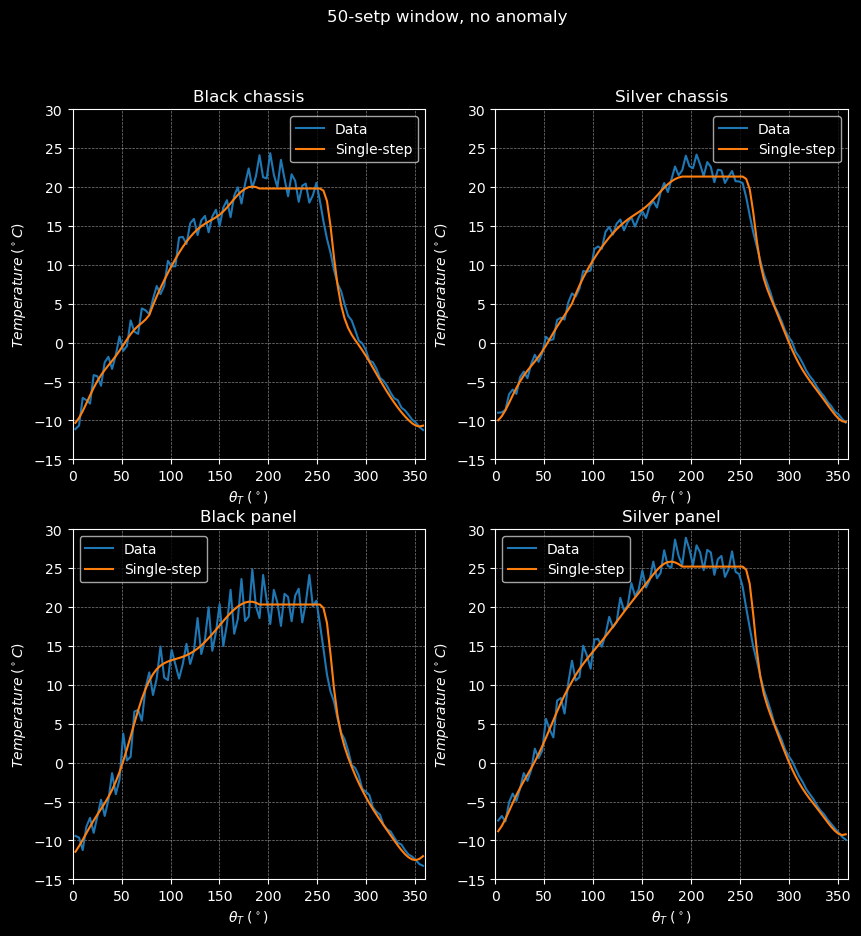

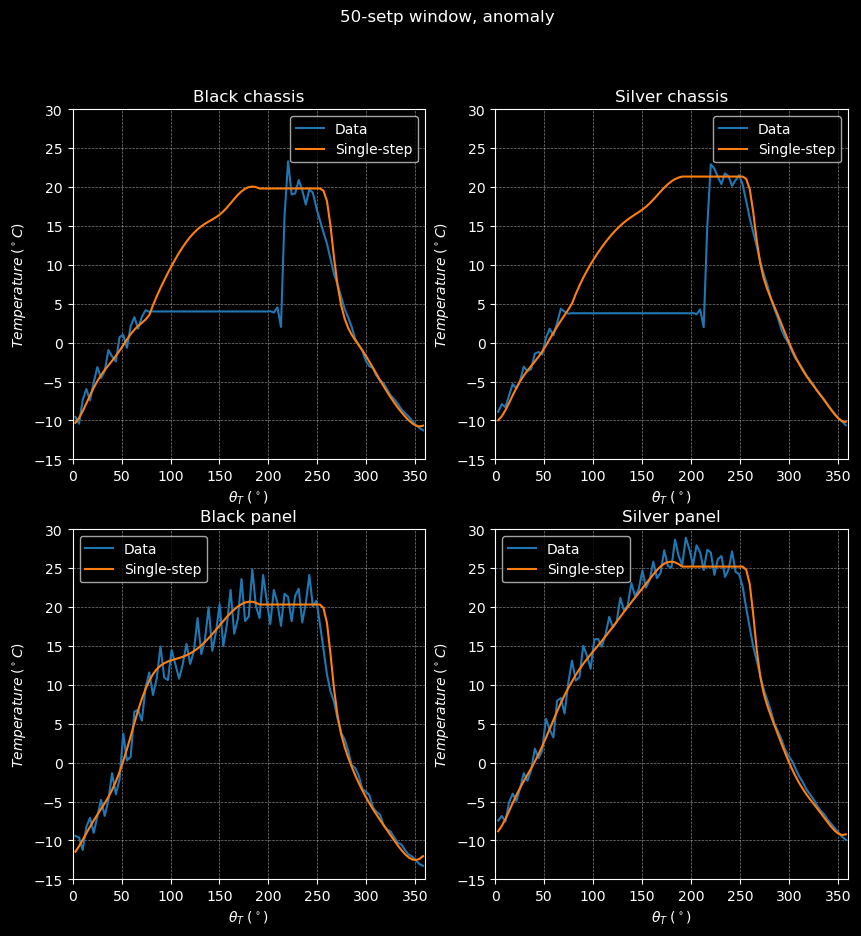

In [13]:
# Orbit without any anomaly:
base_50_df = create_artificial_anomaly(window_size=50,)

base_50_windowed_df, base_50_x, base_50_y = window_data(base_50_df, window_size=50, return_numpy=True, check_continuity=False)

base_50_y_pred, _ = test_model(model_50, base_50_x, single_step_pred=True)

plot_model(
    base_50_windowed_df["theta_T"],
    base_50_y * (max_temp - min_temp) + min_temp,
    base_50_y_pred * (max_temp - min_temp) + min_temp,
    plt_title="50-setp window, no anomaly",
)

# Orbit with anomaly:
anomaly_50_df = create_artificial_anomaly(
    window_size=50,
    anomaly_black_chassis=True,
    anomaly_silver_chassis=True,
)

anomaly_50_windowed_df, anomaly_50_x, anomaly_50_y = window_data(anomaly_50_df, window_size=50, return_numpy=True, check_continuity=False)

anomaly_50_y_pred, _ = test_model(model_50, anomaly_50_x, single_step_pred=True)

plot_model(
    anomaly_50_windowed_df["theta_T"],
    anomaly_50_y * (max_temp - min_temp) + min_temp,
    anomaly_50_y_pred * (max_temp - min_temp) + min_temp,
    plt_title="50-setp window, anomaly",
)

In [12]:
def test_solar_inputs(model, percent_change, x_data, y_data, theta_T):
    reduced_x = x_data * (1 - percent_change)
    increased_x = x_data * (1 + percent_change)

    reduced_y_pred = model.predict(reduced_x, verbose=False)
    increased_y_pred = model.predict(increased_x, verbose=False)

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(
        theta_T,
        y_data[:, 0] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 0] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 0] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Black chassis")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(
        theta_T,
        y_data[:, 1] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 1] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 1] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Silver chassis")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.plot(
        theta_T,
        y_data[:, 2] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 2] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 2] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Black panel")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(
        theta_T,
        y_data[:, 3] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 3] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 3] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Silver panel")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()



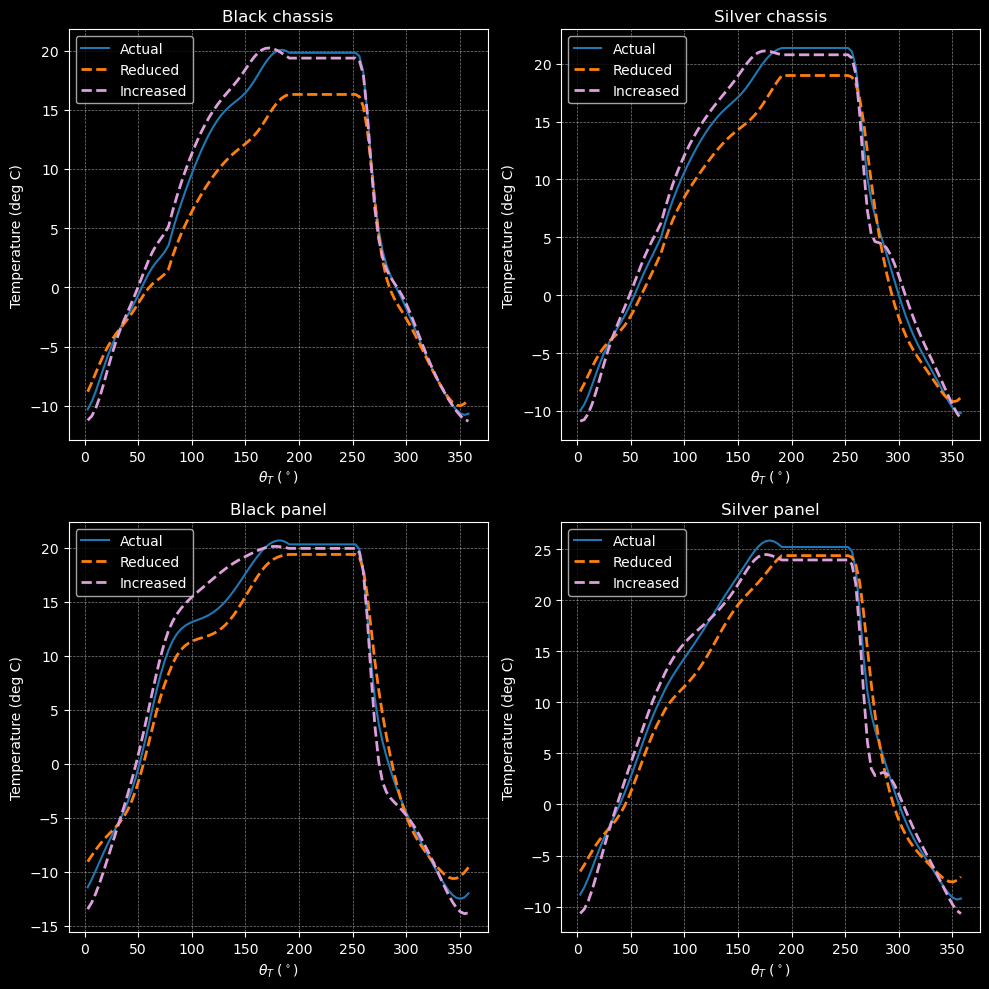

In [15]:
test_solar_inputs(
    model_50, 
    0.1, 
    base_50_x,
    base_50_y_pred,
    base_50_windowed_df["theta_T"].values,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, None, 256)         264192    
                                                                 
 lstm_8 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_9 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_10 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_11 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_12 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_13 (LSTM)              (None, 16)               

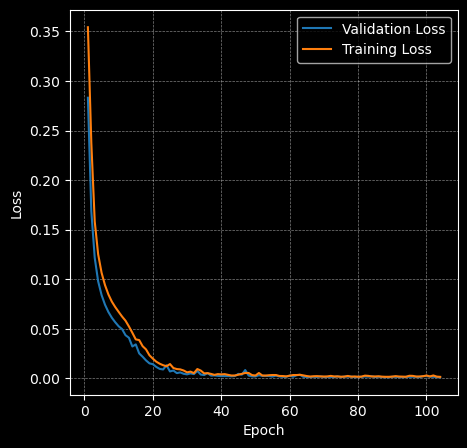

In [16]:
train_68_df, x_train_68, y_train_68 = window_data(train_norm_df, 68, return_numpy=True)
test_68_df, x_test_68, y_test_68 = window_data(test_norm_df, 68, return_numpy=True)

model_68_layers = np.empty(shape=(7), dtype=dict,)
model_68_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_68_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_68_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_68_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_68_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_68_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_68_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_68, recommended_device = create_model(
    model_68_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_68.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_68 = model_68.fit(
        x_train_68,
        y_train_68,
        epochs=250,
        validation_data=(x_test_68, y_test_68),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_68.history["loss"]), len(history_68.history["loss"])),
    history_68.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_68.history["loss"]), len(history_68.history["loss"])),
    history_68.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

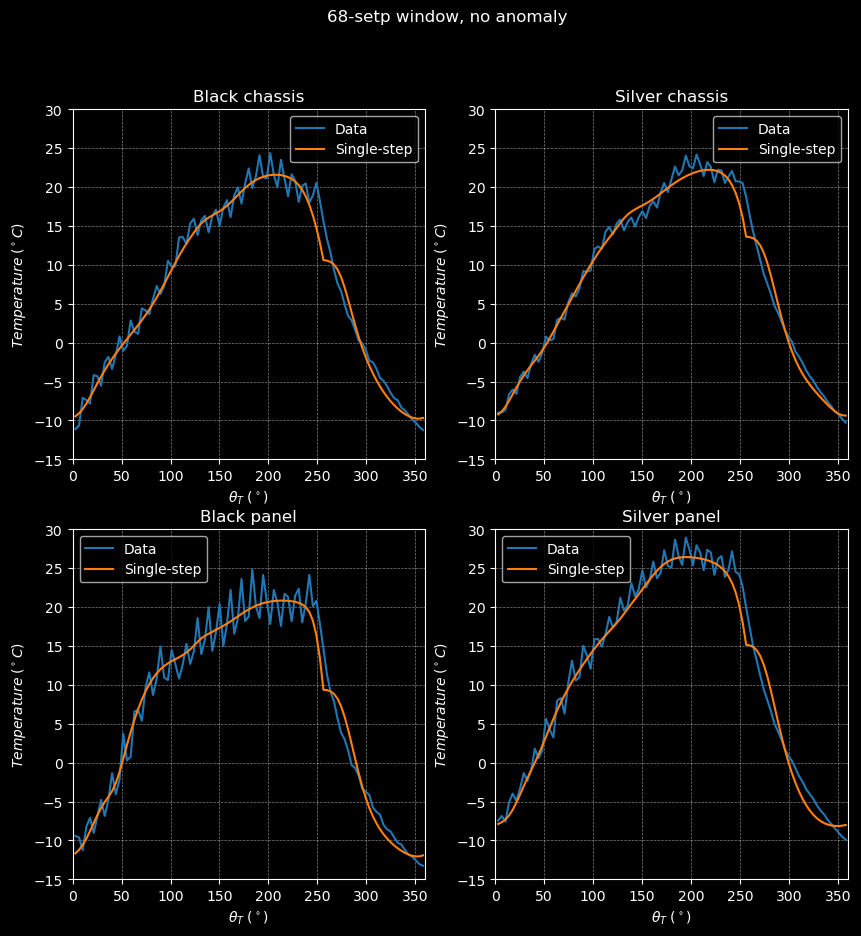

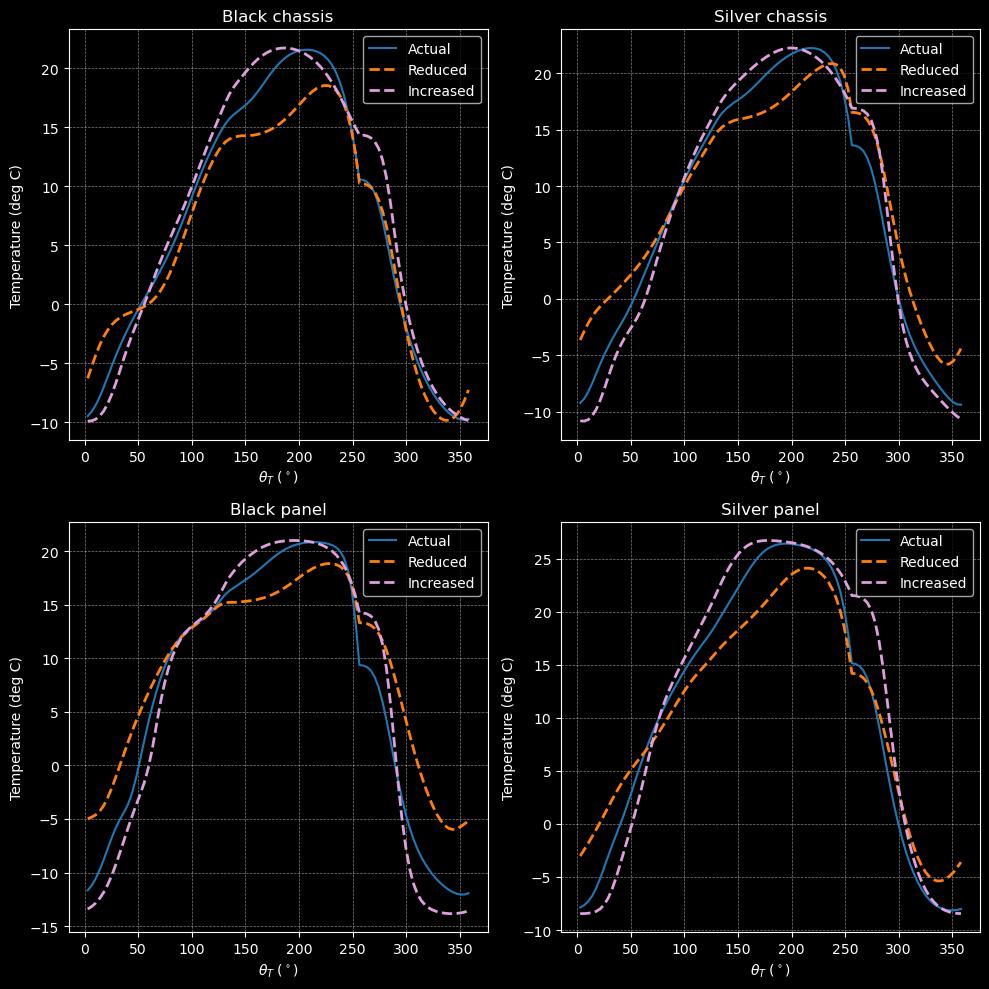

In [17]:
# Orbit without any anomaly:
base_68_df = create_artificial_anomaly(window_size=68,)

base_68_windowed_df, base_68_x, base_68_y = window_data(base_68_df, window_size=68, return_numpy=True, check_continuity=False)

base_68_y_pred, _ = test_model(model_68, base_68_x, single_step_pred=True)

plot_model(
    base_68_windowed_df["theta_T"],
    base_68_y * (max_temp - min_temp) + min_temp,
    base_68_y_pred * (max_temp - min_temp) + min_temp,
    plt_title="68-setp window, no anomaly",
)

test_solar_inputs(
    model_68, 
    0.15, 
    base_68_x,
    base_68_y_pred,
    base_68_windowed_df["theta_T"].values,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 256)         264192    
                                                                 
 lstm_15 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_16 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_17 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_18 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_19 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_20 (LSTM)              (None, 16)               

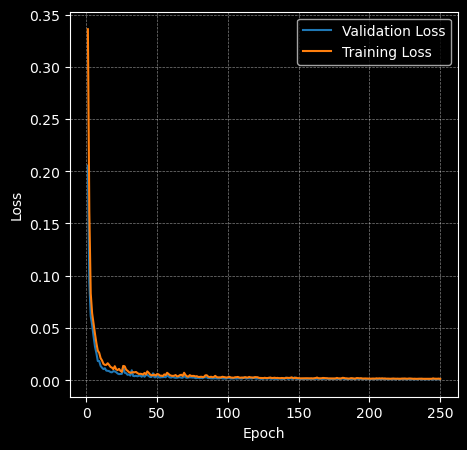

In [18]:
train_60_df, x_train_60, y_train_60 = window_data(train_norm_df, 60, return_numpy=True)
test_60_df, x_test_60, y_test_60 = window_data(test_norm_df, 60, return_numpy=True)

model_60_layers = np.empty(shape=(7), dtype=dict,)
model_60_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_60_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_60_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_60_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_60_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_60_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_60_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_60, recommended_device = create_model(
    model_60_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_60.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_60 = model_60.fit(
        x_train_60,
        y_train_60,
        epochs=250,
        validation_data=(x_test_60, y_test_60),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_60.history["loss"]), len(history_60.history["loss"])),
    history_60.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_60.history["loss"]), len(history_60.history["loss"])),
    history_60.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

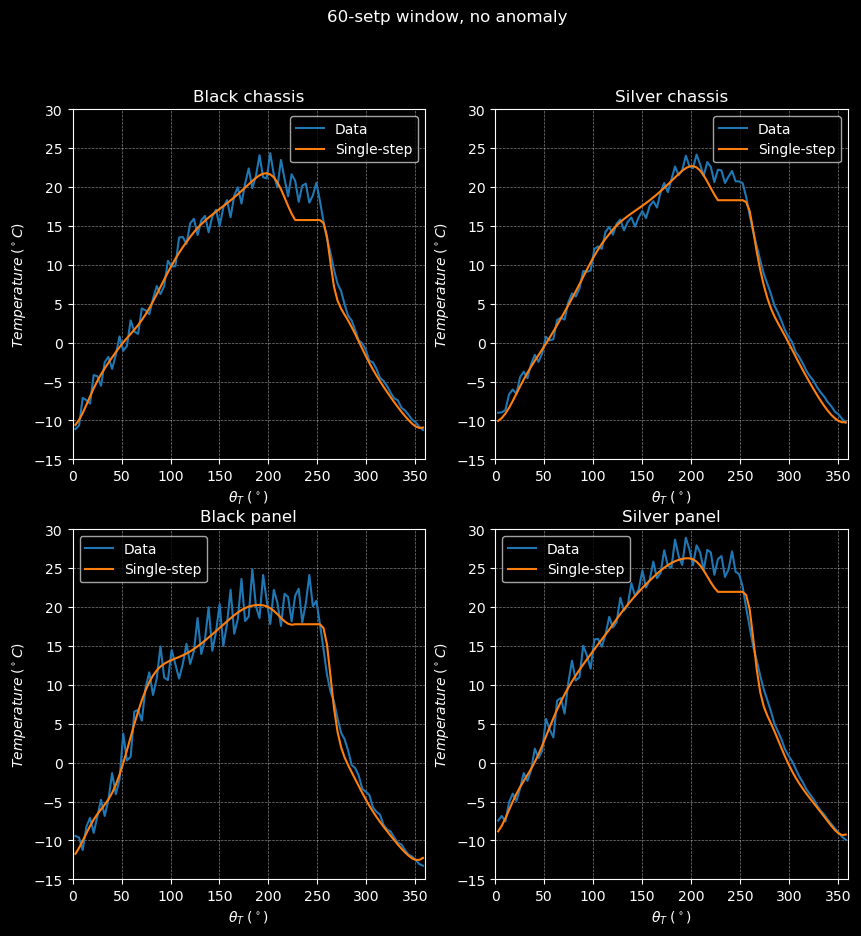

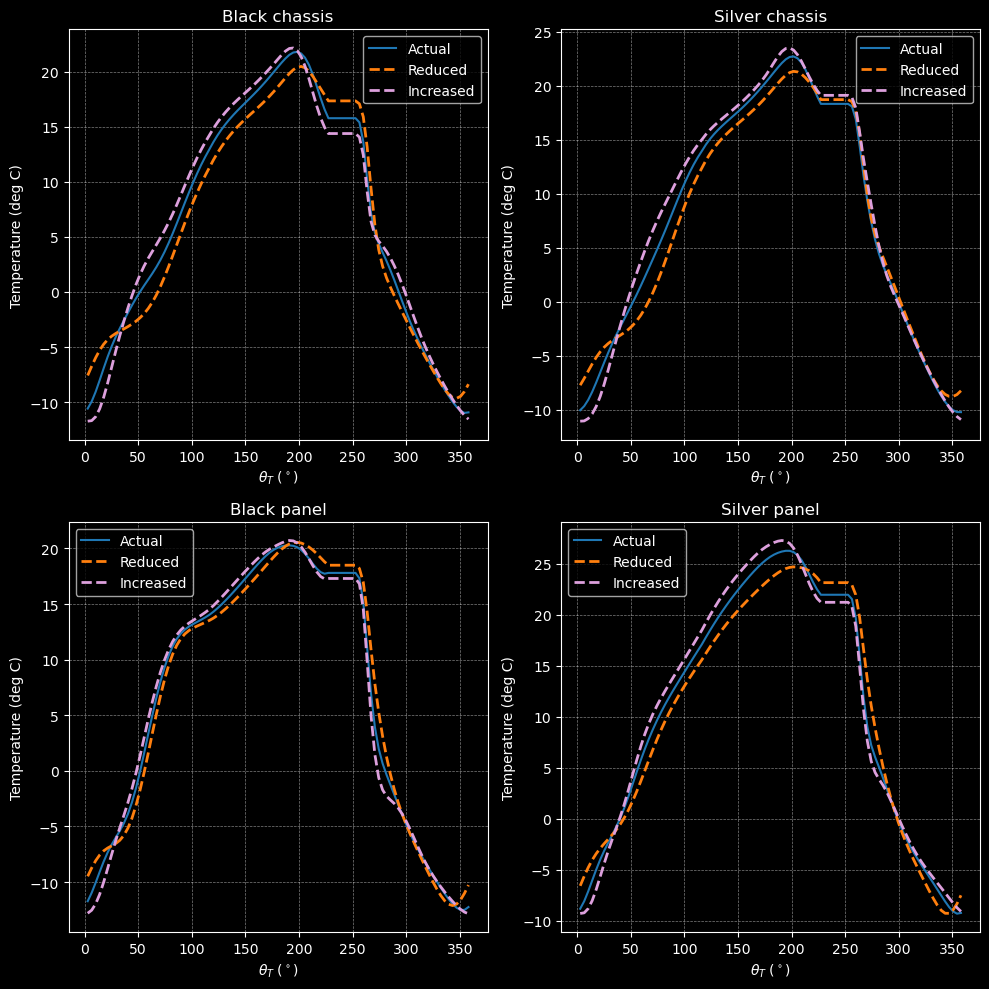

In [19]:
# Orbit without any anomaly:
base_60_df = create_artificial_anomaly(window_size=60,)

base_60_windowed_df, base_60_x, base_60_y = window_data(base_60_df, window_size=60, return_numpy=True, check_continuity=False)

base_60_y_pred, _ = test_model(model_60, base_60_x, single_step_pred=True)

plot_model(
    base_60_windowed_df["theta_T"],
    base_60_y * (max_temp - min_temp) + min_temp,
    base_60_y_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-setp window, no anomaly",
)

test_solar_inputs(
    model_60, 
    0.1, 
    base_60_x,
    base_60_y_pred,
    base_60_windowed_df["theta_T"].values,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, None, 256)         264192    
                                                                 
 lstm_22 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_23 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_24 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_25 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_26 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_27 (LSTM)              (None, 16)               

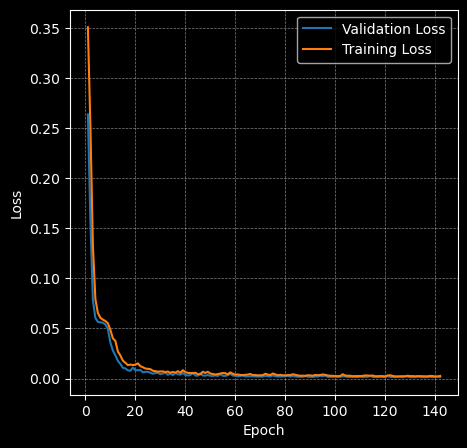

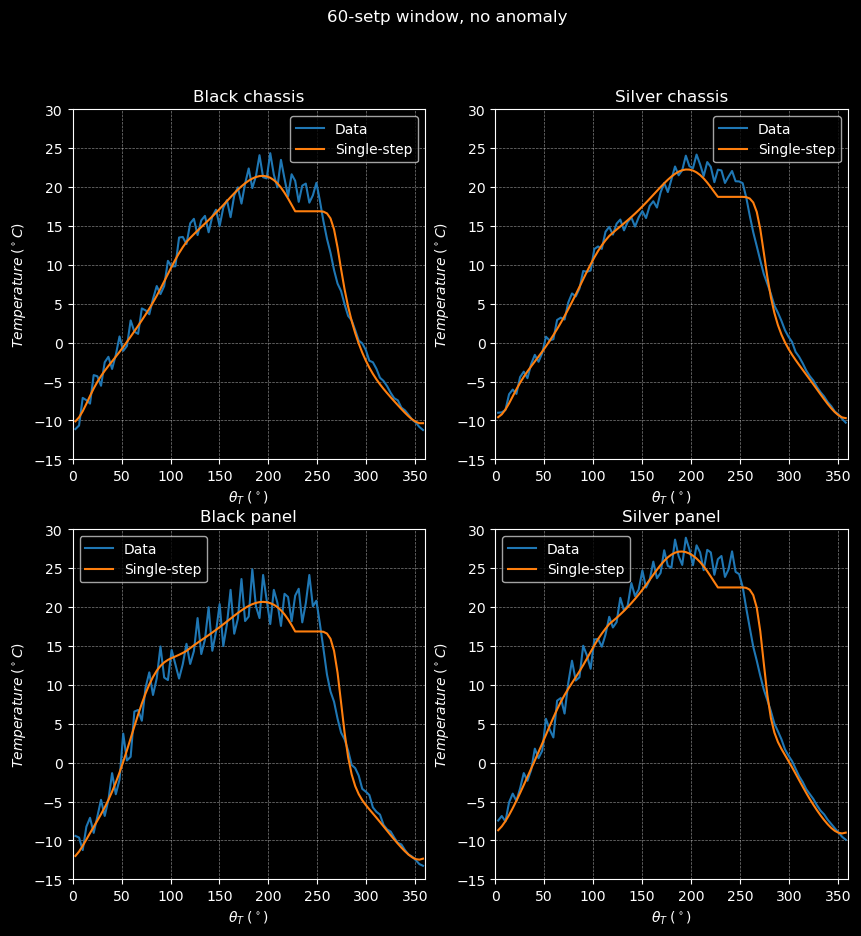

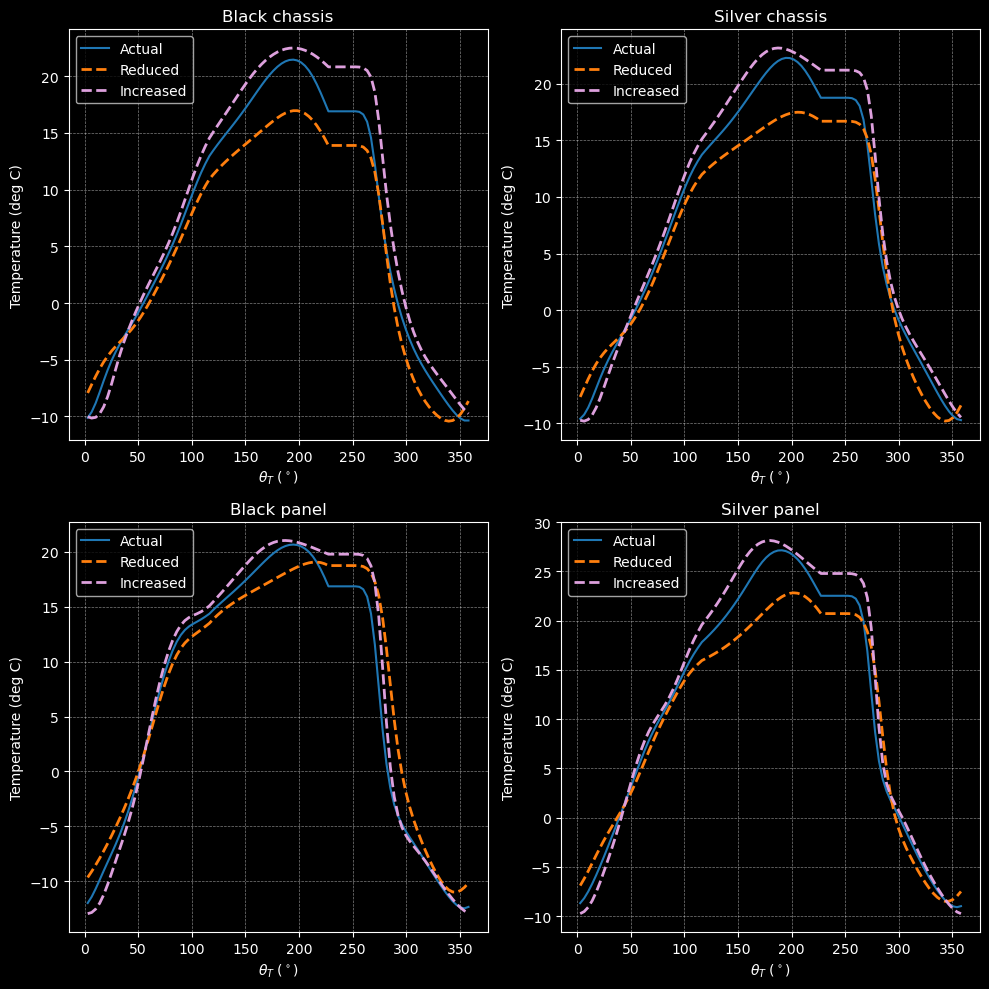

In [20]:
train_60_df, x_train_60, y_train_60 = window_data(train_norm_df, 60, return_numpy=True)
test_60_df, x_test_60, y_test_60 = window_data(test_norm_df, 60, return_numpy=True)

model_60_layers = np.empty(shape=(7), dtype=dict,)
model_60_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_60_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_60_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_60_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_60_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_60_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_60_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_60, recommended_device = create_model(
    model_60_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_60.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_60 = model_60.fit(
        x_train_60,
        y_train_60,
        epochs=250,
        validation_data=(x_test_60, y_test_60),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_60.history["loss"]), len(history_60.history["loss"])),
    history_60.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_60.history["loss"]), len(history_60.history["loss"])),
    history_60.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
# Orbit without any anomaly:
base_60_df = create_artificial_anomaly(window_size=60,)

base_60_windowed_df, base_60_x, base_60_y = window_data(base_60_df, window_size=60, return_numpy=True, check_continuity=False)

base_60_y_pred, _ = test_model(model_60, base_60_x, single_step_pred=True)

plot_model(
    base_60_windowed_df["theta_T"],
    base_60_y * (max_temp - min_temp) + min_temp,
    base_60_y_pred * (max_temp - min_temp) + min_temp,
    plt_title="60-setp window, no anomaly",
)

test_solar_inputs(
    model_60, 
    0.1, 
    base_60_x,
    base_60_y_pred,
    base_60_windowed_df["theta_T"].values,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

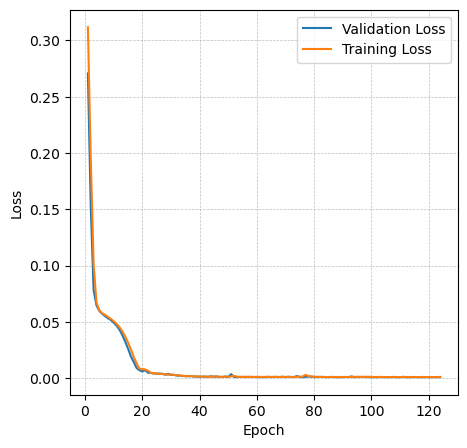

In [13]:
train_97_df, x_train_97, y_train_97 = window_data(train_norm_df, 97, return_numpy=True)
test_97_df, x_test_97, y_test_97 = window_data(test_norm_df, 97, return_numpy=True)

model_97_layers = np.empty(shape=(7), dtype=dict,)
model_97_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_97_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_97_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_97_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_97_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_97_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_97_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_97, recommended_device = create_model(
    model_97_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_97.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_97 = model_97.fit(
        x_train_97,
        y_train_97,
        epochs=250,
        validation_data=(x_test_97, y_test_97),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

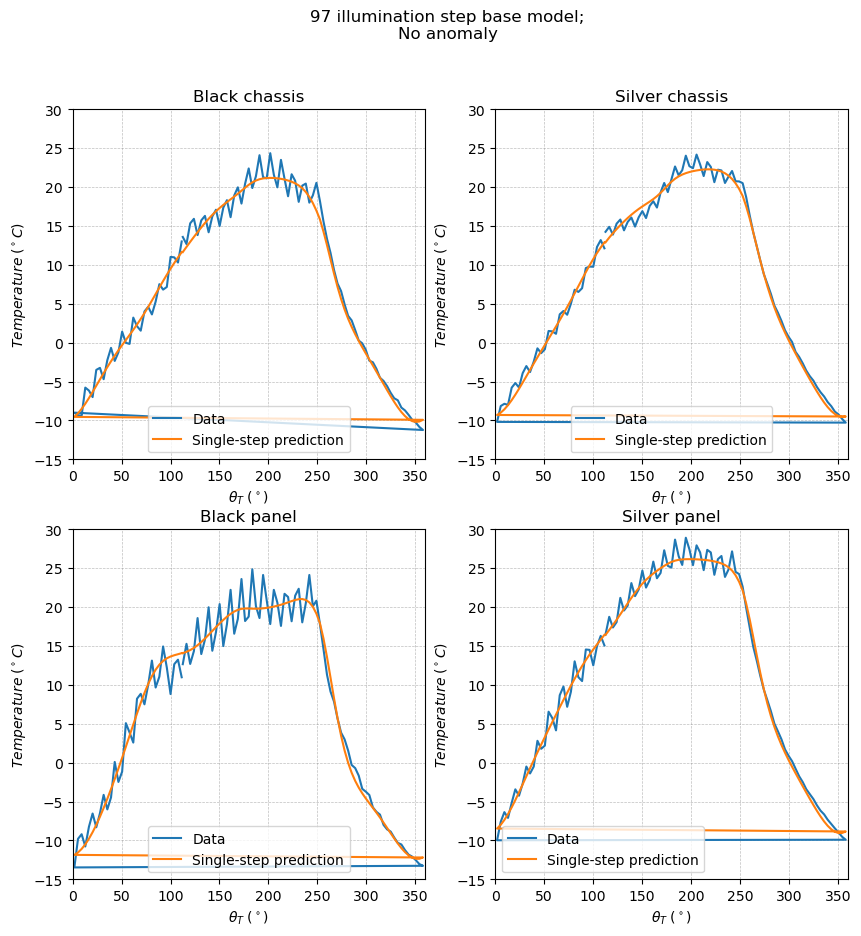

In [14]:
y_pred_97 = model_97.predict(x_test_97, verbose=0)

plot_model(
    test_97_df["theta_T"][:98],
    y_test_97[:98] * (max_temp - min_temp) + min_temp,
    y_pred_97[:98] * (max_temp - min_temp) + min_temp,
    plt_title="97 illumination step base model;\nNo anomaly",
)

# test_solar_inputs(
#     model_97,
#     0.01,
#     x_test_97[:98],
#     y_pred_97[:98],
#     test_97_df["theta_T"].values[:98],
# )

4/4 [==============================] - 0s 57ms/step


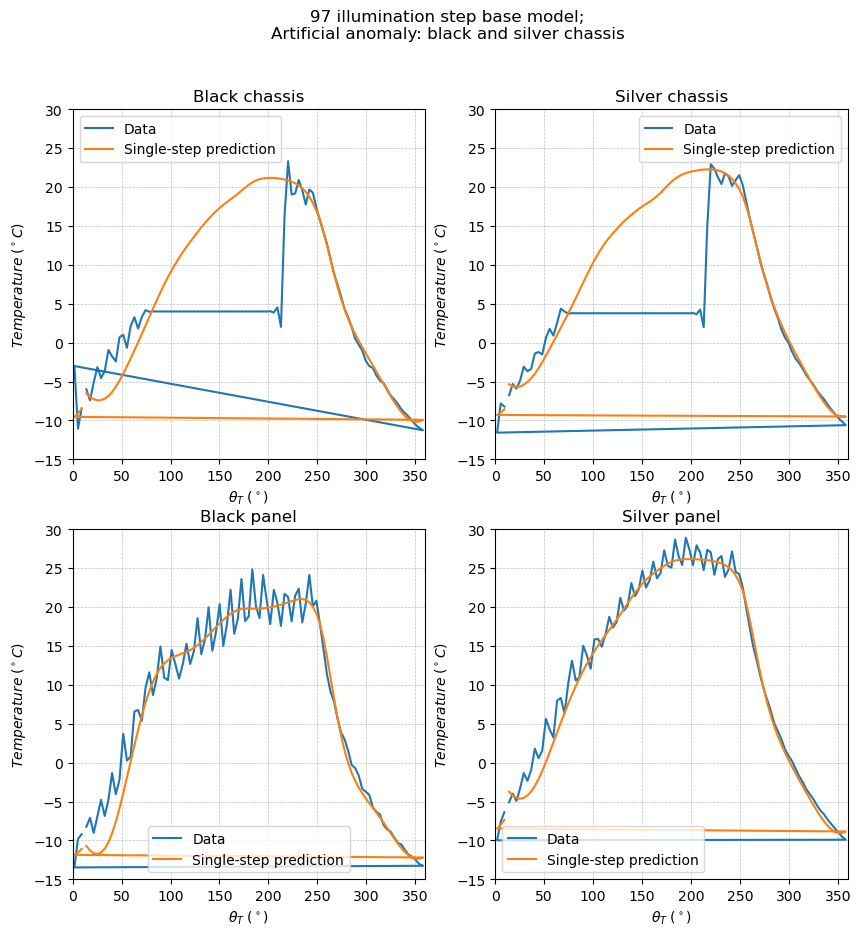

In [18]:
anomaly_97_df = create_artificial_anomaly(
    window_size=97,
    anomaly_black_chassis=True,
    anomaly_silver_chassis=True,
)

anomaly_50_windowed_df, anomaly_50_x, anomaly_50_y = window_data(anomaly_97_df, 97, return_numpy=True, check_continuity=False)

y_pred_anomaly = model_97.predict(anomaly_50_x)

plot_model(
    anomaly_50_windowed_df["theta_T"],
    (anomaly_50_y) * (max_temp - min_temp) + min_temp,
    (y_pred_anomaly) * (max_temp - min_temp) + min_temp,
    plt_title="97 illumination step base model;\nArtificial anomaly: black and silver chassis",
)

In [16]:
def window_data_v2(df, window_size, base_model, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["input black chassis temp"],
        ["input silver chassis temp"],
        ["input black panel temp"],
        ["input silver panel temp"],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))
    with alive_bar(total=len(window_df), theme='classic', force_tty=True) as bar:
        for i in range(len(window_df)):
            if check_continuity:
                if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                    bar()
                    continue
            
            window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
            window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
            if i==0:
                bar()
                continue
            x_pred = np.empty(shape=(1, window_size, 1))
            x_pred[0, :, 0] = window_df.iloc[i - 1, 1:window_size + 1].values
            y_pred = base_model.predict(x_pred, verbose=0)
            window_df.loc[i, "input black chassis temp"] = y_pred[0][0]
            window_df.loc[i, "input silver chassis temp"] = y_pred[0][1]
            window_df.loc[i, "input black panel temp"] = y_pred[0][2]
            window_df.loc[i, "input silver panel temp"] = y_pred[0][3]
            window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]
            bar()

    window_df = window_df.dropna().reset_index(drop=True)
    
    # x_pred = np.empty(shape=(len(window_df), window_size, 1))
    # x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    # y_pred = base_model.predict(x_pred, verbose=1)
    # window_df["input black chassis temp"] = y_pred[:, 0]
    # window_df["input silver chassis temp"] = y_pred[:, 1]
    # window_df["input black panel temp"] = y_pred[:, 2]
    # window_df["input silver panel temp"] = y_pred[:, 3]
    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), window_size, 5), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[1:window_size + 1]
            x_data[i, :, 1] = row["input black chassis temp"]
            x_data[i, :, 2] = row["input silver chassis temp"]
            x_data[i, :, 3] = row["input black panel temp"]
            x_data[i, :, 4] = row["input silver panel temp"]
            y_data[i, 0] = row["black chassis temp"] - row["input black chassis temp"]
            y_data[i, 1] = row["silver chassis temp"] - row["input silver chassis temp"]
            y_data[i, 2] = row["black panel temp"] - row["input black panel temp"]
            y_data[i, 3] = row["silver panel temp"] - row["input silver panel temp"]

        return window_df, x_data, y_data

    return window_df

In [17]:
train_97_res_df, x_train_97_res, y_train_97_res = window_data_v2(train_norm_df, 97, model_97, return_numpy=True)
test_97_red_df, x_test_97_res, y_test_97_res = window_data_v2(test_norm_df, 97, model_97, return_numpy=True)


[========================================] 835/835 [100%] in 24.7s (33.86/s)                                            
[========================================] 137/137 [100%] in 8.1s (16.98/s)                                             


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, None, 256)         268288    
                                                                 
 lstm_8 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_9 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_10 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_11 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_12 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_13 (LSTM)              (None, 16)               

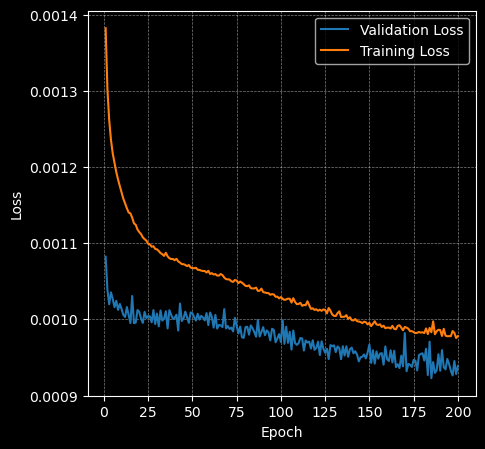

In [18]:
model_97_res, recommended_device = create_model(
    model_97_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-6),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 5),
)

model_97_res.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_97_res = model_97_res.fit(
        x_train_97_res,
        y_train_97_res,
        epochs=200,
        validation_data=(x_test_97_res, y_test_97_res),
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [19]:
y_pred = model_97_res.predict(x_test_97_res) + x_test_97_res[:, -1, 1:5]


4/4 [==============================] - 2s 25ms/step


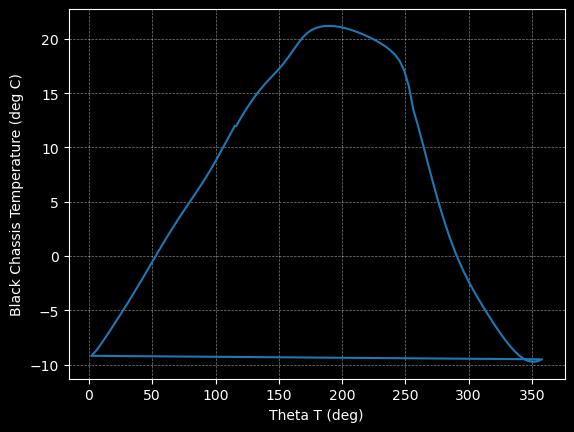

In [20]:
plt.plot(
    test_97_red_df["theta_T"][:98],
    y_pred[:98, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
)
plt.xlabel("Theta T (deg)")
plt.ylabel("Black Chassis Temperature (deg C)")
plt.grid()

In [23]:
def window_data_v3(df, window_size, base_model, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["prev black chassis temp 0"],
        ["prev silver chassis temp 0"],
        ["prev black panel temp 0"],
        ["prev silver panel temp 0"],
        ["prev black chassis temp 1"],
        ["prev silver chassis temp 1"],
        ["prev black panel temp 1"],
        ["prev silver panel temp 1"],
        ["prev black chassis temp 2"],
        ["prev silver chassis temp 2"],
        ["prev black panel temp 2"],
        ["prev silver panel temp 2"],
        ["black chassis temp prediction"],
        ["silver chassis temp prediction"],
        ["black panel temp prediction"],
        ["silver panel temp prediction"],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))
    with alive_bar(total=len(window_df), theme='classic', force_tty=True) as bar:
        for i in range(len(window_df)):
            if check_continuity:
                if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                    bar()
                    continue
            
            window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
            window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
            if i<3:
                bar()
                continue
            window_df.loc[i, "prev black chassis temp 0"] = df.loc[i - 3, "black chassis temperature (deg C)"]
            window_df.loc[i, "prev silver chassis temp 0"] = df.loc[i - 3, "silver chassis temperature (deg C)"]
            window_df.loc[i, "prev black panel temp 0"] = df.loc[i - 3, "black panel temperature (deg C)"]
            window_df.loc[i, "prev silver panel temp 0"] = df.loc[i - 3, "silver panel temperature (deg C)"]
            window_df.loc[i, "prev black chassis temp 1"] = df.loc[i - 2, "black chassis temperature (deg C)"]
            window_df.loc[i, "prev silver chassis temp 1"] = df.loc[i - 2, "silver chassis temperature (deg C)"]
            window_df.loc[i, "prev black panel temp 1"] = df.loc[i - 2, "black panel temperature (deg C)"]
            window_df.loc[i, "prev silver panel temp 1"] = df.loc[i - 2, "silver panel temperature (deg C)"]
            window_df.loc[i, "prev black chassis temp 2"] = df.loc[i - 1, "black chassis temperature (deg C)"]
            window_df.loc[i, "prev silver chassis temp 2"] = df.loc[i - 1, "silver chassis temperature (deg C)"]
            window_df.loc[i, "prev black panel temp 2"] = df.loc[i - 1, "black panel temperature (deg C)"]
            window_df.loc[i, "prev silver panel temp 2"] = df.loc[i - 1, "silver panel temperature (deg C)"]

            window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]
            bar()

    window_df = window_df.dropna(how='all').reset_index(drop=True)
    x_pred = np.empty(shape=(len(window_df), window_size, 1), dtype=np.float64)
    x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    y_pred = base_model.predict(x_pred, verbose=0)
    window_df["black chassis temp prediction"] = y_pred[:, 0]
    window_df["silver chassis temp prediction"] = y_pred[:, 1]
    window_df["black panel temp prediction"] = y_pred[:, 2]
    window_df["silver panel temp prediction"] = y_pred[:, 3]
    
    
    # x_pred = np.empty(shape=(len(window_df), window_size, 1))
    # x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    # y_pred = base_model.predict(x_pred, verbose=1)
    # window_df["input black chassis temp"] = y_pred[:, 0]
    # window_df["input silver chassis temp"] = y_pred[:, 1]
    # window_df["input black panel temp"] = y_pred[:, 2]
    # window_df["input silver panel temp"] = y_pred[:, 3]
    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 17), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["prev black chassis temp 0"]
            x_data[i, 2] = row["prev silver chassis temp 0"]
            x_data[i, 3] = row["prev black panel temp 0"]
            x_data[i, 4] = row["prev silver panel temp 0"]
            x_data[i, 5] = row["prev black chassis temp 1"]
            x_data[i, 6] = row["prev silver chassis temp 1"]
            x_data[i, 7] = row["prev black panel temp 1"]
            x_data[i, 8] = row["prev silver panel temp 1"]
            x_data[i, 9] = row["prev black chassis temp 2"]
            x_data[i, 10] = row["prev silver chassis temp 2"]
            x_data[i, 11] = row["prev black panel temp 2"]
            x_data[i, 12] = row["prev silver panel temp 2"]
            x_data[i, 13] = row["black chassis temp prediction"]
            x_data[i, 14] = row["silver chassis temp prediction"]
            x_data[i, 15] = row["black panel temp prediction"]
            x_data[i, 16] = row["silver panel temp prediction"]
            y_data[i, 0] = row["black chassis temp"] - row["black chassis temp prediction"]
            y_data[i, 1] = row["silver chassis temp"] - row["silver chassis temp prediction"]
            y_data[i, 2] = row["black panel temp"] - row["black panel temp prediction"]
            y_data[i, 3] = row["silver panel temp"] - row["silver panel temp prediction"]

        return window_df, x_data, y_data

    return window_df

In [24]:
train_97_res_df_2, x_train_97_res_2, y_train_97_res_2 = window_data_v3(train_norm_df, 97, model_97, return_numpy=True)
test_97_red_df_2, x_test_97_res_2, y_test_97_res_2 = window_data_v3(test_norm_df, 97, model_97, return_numpy=True)


[========================================] 835/835 [100%] in 0.5s (1539.32/s)                                           
[========================================] 137/137 [100%] in 0.2s (704.75/s)                                            


In [114]:
y_train_97_res_2 = (y_train_97_res_2 + min_temp) / (max_temp - min_temp)

In [96]:
y_train_97_res_2 = y_train_97_res_2 * 10
y_test_97_res_2 = y_test_97_res_2 * 10

Epoch 1/1000
11/11 [==============================] - 1s 36ms/step - loss: 0.0011 - mean_absolute_error: 0.0256 - val_loss: 9.1028e-04 - val_mean_absolute_error: 0.0231
Epoch 2/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0010 - mean_absolute_error: 0.0249 - val_loss: 9.0275e-04 - val_mean_absolute_error: 0.0229
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 9.9619e-04 - mean_absolute_error: 0.0246 - val_loss: 9.0632e-04 - val_mean_absolute_error: 0.0230
Epoch 4/1000
11/11 [==============================] - 0s 9ms/step - loss: 9.8406e-04 - mean_absolute_error: 0.0245 - val_loss: 9.0265e-04 - val_mean_absolute_error: 0.0230
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 9.7238e-04 - mean_absolute_error: 0.0243 - val_loss: 9.0027e-04 - val_mean_absolute_error: 0.0230
Epoch 6/1000
11/11 [==============================] - 0s 9ms/step - loss: 9.6025e-04 - mean_absolute_error: 0.0241 - val_loss: 9.0477e-04 - val_me

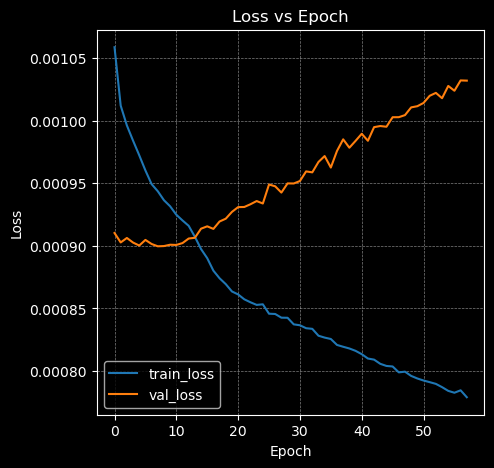

In [49]:
model_97_res_2 = tf.keras.Sequential()
model_97_res_2.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(17,)))
model_97_res_2.add(tf.keras.layers.Dense(256, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(256, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(64, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(32, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(16, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(8, activation="relu"))
model_97_res_2.add(tf.keras.layers.Dense(4, activation="linear"))

model_97_res_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

with tf.device("/GPU:0"):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=50,
        restore_best_weights=True
    )

    history_97_res_2 = model_97_res_2.fit(
        x_train_97_res_2,
        y_train_97_res_2,
        epochs=1000,
        validation_data=(x_test_97_res_2, y_test_97_res_2),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(history_97_res_2.history["loss"], label="train_loss", color=plt_colors[0])
plt.plot(history_97_res_2.history["val_loss"], label="val_loss", color=plt_colors[1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.legend()
plt.show()


In [50]:
y_pred = model_97_res_2.predict(x_test_97_res_2) + x_test_97_res_2[:, 13:17]

4/4 [==============================] - 0s 2ms/step


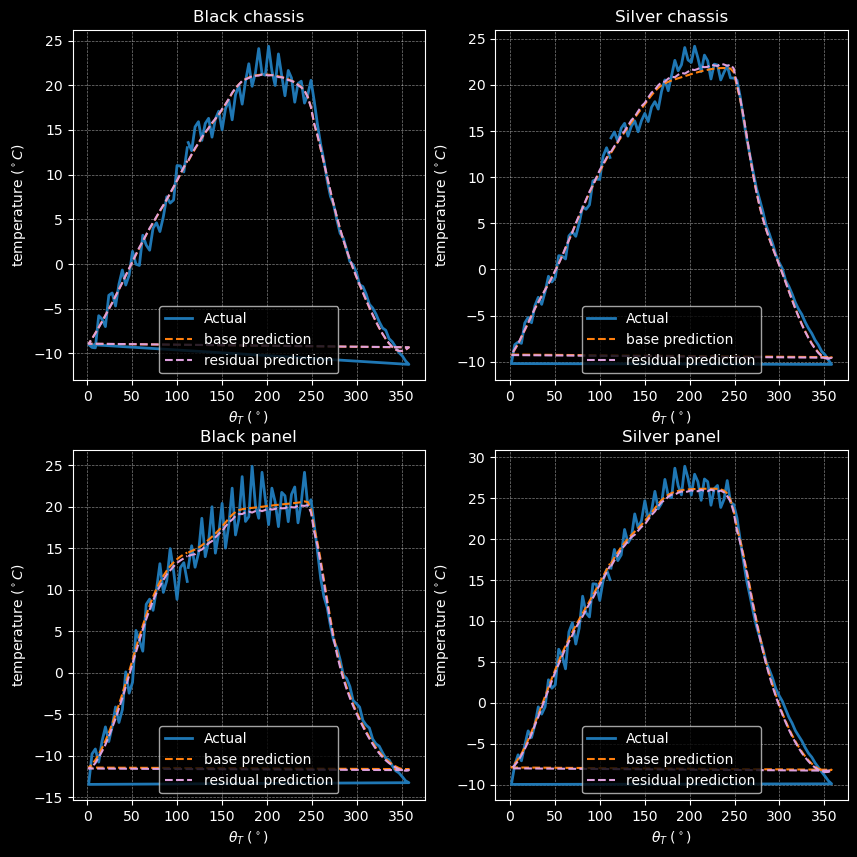

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_test_97[:98, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linewidth=2,
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred_97[:98, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="base prediction",
    linestyle="--",
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred[:98, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="residual prediction",
    linestyle="--",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"temperature ($^\circ C$)")
plt.title("Black chassis")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_test_97[:98, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linewidth=2,
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred_97[:98, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="base prediction",
    linestyle="--",
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred[:98, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="residual prediction",
    linestyle="--",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"temperature ($^\circ C$)")
plt.title("Silver chassis")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_test_97[:98, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linewidth=2,
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred_97[:98, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="base prediction",
    linestyle="--",
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred[:98, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="residual prediction",
    linestyle="--",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"temperature ($^\circ C$)")
plt.title("Black panel")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_test_97[:98, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linewidth=2,
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred_97[:98, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="base prediction",
    linestyle="--",
)
plt.plot(
    test_97_red_df_2["theta_T"][:98],
    y_pred[:98, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="residual prediction",
    linestyle="--",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"temperature ($^\circ C$)")
plt.title("Silver panel")
plt.legend()
plt.grid()

plt.show()
plt.close()

In [43]:
def window_data_v4(df, window_size, base_model, return_numpy=False, check_continuity=True, return_y_actual=False):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["prev black chassis temp 0"],
        ["prev silver chassis temp 0"],
        ["prev black panel temp 0"],
        ["prev silver panel temp 0"],
        ["prev black chassis temp 1"],
        ["prev silver chassis temp 1"],
        ["prev black panel temp 1"],
        ["prev silver panel temp 1"],
        ["prev black chassis temp 2"],
        ["prev silver chassis temp 2"],
        ["prev black panel temp 2"],
        ["prev silver panel temp 2"],
        ["black chassis temp prediction"],
        ["silver chassis temp prediction"],
        ["black panel temp prediction"],
        ["silver panel temp prediction"],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))
    with alive_bar(total=len(window_df), theme='classic', force_tty=True) as bar:
        for i in range(len(window_df)):
            if check_continuity:
                if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                    bar()
                    continue
            
            window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
            window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
            if i<3:
                bar()
                continue
            window_df.loc[i, "prev black chassis temp 0"] = df.loc[i - 3, "black chassis temperature (deg C)"]
            window_df.loc[i, "prev silver chassis temp 0"] = df.loc[i - 3, "silver chassis temperature (deg C)"]
            window_df.loc[i, "prev black panel temp 0"] = df.loc[i - 3, "black panel temperature (deg C)"]
            window_df.loc[i, "prev silver panel temp 0"] = df.loc[i - 3, "silver panel temperature (deg C)"]
            window_df.loc[i, "prev black chassis temp 1"] = df.loc[i - 2, "black chassis temperature (deg C)"]
            window_df.loc[i, "prev silver chassis temp 1"] = df.loc[i - 2, "silver chassis temperature (deg C)"]
            window_df.loc[i, "prev black panel temp 1"] = df.loc[i - 2, "black panel temperature (deg C)"]
            window_df.loc[i, "prev silver panel temp 1"] = df.loc[i - 2, "silver panel temperature (deg C)"]
            window_df.loc[i, "prev black chassis temp 2"] = df.loc[i - 1, "black chassis temperature (deg C)"]
            window_df.loc[i, "prev silver chassis temp 2"] = df.loc[i - 1, "silver chassis temperature (deg C)"]
            window_df.loc[i, "prev black panel temp 2"] = df.loc[i - 1, "black panel temperature (deg C)"]
            window_df.loc[i, "prev silver panel temp 2"] = df.loc[i - 1, "silver panel temperature (deg C)"]

            window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]
            bar()

    window_df = window_df.dropna(how='all').reset_index(drop=True)
    x_pred = np.empty(shape=(len(window_df), window_size, 1), dtype=np.float64)
    x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    y_pred = base_model.predict(x_pred, verbose=0)
    window_df["black chassis temp prediction"] = y_pred[:, 0]
    window_df["silver chassis temp prediction"] = y_pred[:, 1]
    window_df["black panel temp prediction"] = y_pred[:, 2]
    window_df["silver panel temp prediction"] = y_pred[:, 3]
    
    
    # x_pred = np.empty(shape=(len(window_df), window_size, 1))
    # x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    # y_pred = base_model.predict(x_pred, verbose=1)
    # window_df["input black chassis temp"] = y_pred[:, 0]
    # window_df["input silver chassis temp"] = y_pred[:, 1]
    # window_df["input black panel temp"] = y_pred[:, 2]
    # window_df["input silver panel temp"] = y_pred[:, 3]
    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), window_size, 5), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)
        y_actual = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[1:window_size + 1].to_numpy()
            x_data[i, :, 1] = row.loc["prev black chassis temp 2"]
            x_data[i, :, 2] = row.loc["prev silver chassis temp 2"]
            x_data[i, :, 3] = row.loc["prev black panel temp 2"]
            x_data[i, :, 4] = row.loc["prev silver panel temp 2"]
            y_data[i, 0] = row.loc["black chassis temp"] - row.loc["black chassis temp prediction"]
            y_data[i, 1] = row.loc["silver chassis temp"] - row.loc["silver chassis temp prediction"]
            y_data[i, 2] = row.loc["black panel temp"] - row.loc["black panel temp prediction"]
            y_data[i, 3] = row.loc["silver panel temp"] - row.loc["silver panel temp prediction"]
            y_actual[i, 0] = row.loc["black chassis temp"]
            y_actual[i, 1] = row.loc["silver chassis temp"]
            y_actual[i, 2] = row.loc["black panel temp"]
            y_actual[i, 3] = row.loc["silver panel temp"]

        if return_y_actual:
            return window_df, x_data, y_data, y_actual
            
        return window_df, x_data, y_data

    return window_df

[========================================] 835/835 [100%] in 1.0s (848.38/s)                                            
[========================================] 137/137 [100%] in 0.3s (420.66/s)                                            
Epoch 1/200
11/11 [==============================] - 20s 483ms/step - loss: 9.0811e-04 - mean_absolute_error: 0.0229 - val_loss: 8.0202e-04 - val_mean_absolute_error: 0.0219
Epoch 2/200
11/11 [==============================] - 1s 114ms/step - loss: 8.8042e-04 - mean_absolute_error: 0.0225 - val_loss: 8.0613e-04 - val_mean_absolute_error: 0.0220
Epoch 3/200
11/11 [==============================] - 1s 116ms/step - loss: 8.8539e-04 - mean_absolute_error: 0.0226 - val_loss: 8.0099e-04 - val_mean_absolute_error: 0.0221
Epoch 4/200
11/11 [==============================] - 1s 113ms/step - loss: 8.7906e-04 - mean_absolute_error: 0.0226 - val_loss: 8.4885e-04 - val_mean_absolute_error: 0.0227
Epoch 5/200
11/11 [==============================] - 1s 117ms/ste

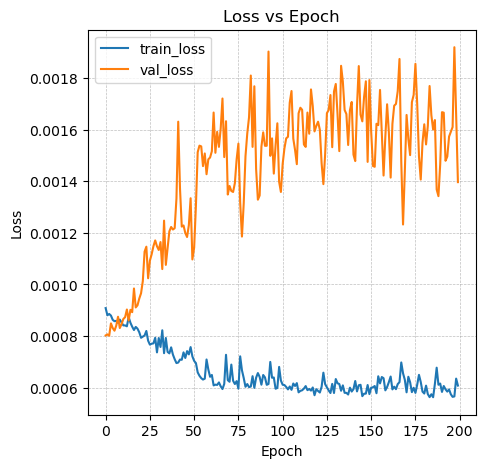

In [23]:
train_97_res_df_3, x_train_97_res_3, y_train_97_res_3 = window_data_v4(train_norm_df, 97, model_97, return_numpy=True)
test_97_red_df_3, x_test_97_res_3, y_test_97_res_3 = window_data_v4(test_norm_df, 97, model_97, return_numpy=True)

model_97_res_3, recommended_device = create_model(
    model_97_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    [tf.keras.metrics.MeanAbsoluteError()],
    input_shape=(None, 5)
)


with tf.device("/GPU:0"):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True
    )

    history_97_res_3 = model_97_res_3.fit(
        x_train_97_res_3,
        y_train_97_res_3,
        epochs=200,
        validation_data=(x_test_97_res_3, y_test_97_res_3),

    )

plt.figure(figsize=(5, 5))
plt.plot(history_97_res_3.history["loss"], label="train_loss", color=plt_colors[0])
plt.plot(history_97_res_3.history["val_loss"], label="val_loss", color=plt_colors[1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.legend()
plt.show()

In [51]:
anomaly_97_df = create_artificial_anomaly(
    window_size=97,
    anomaly_black_chassis=True,
    anomaly_silver_chassis=True,
)

anomaly_50_windowed_df, anomaly_50_x, anomaly_50_y, y_actual = window_data_v4(anomaly_97_df, 97, model_97, return_numpy=True, check_continuity=False, return_y_actual=True)

y_base = model_97.predict(anomaly_50_x[:, :, 0:1])
y_res = model_97_res_3.predict(anomaly_50_x) + y_base

# # y_pred_res_3 = model_97_res_3.predict(x_test_97_res_3)
# y_actual = y_test_97
# y_base = model_97.predict(x_test_97)
# y_res = model_97_res_3.predict(x_test_97_res_3) + y_base



[========================================] 97/97 [100%] in 0.3s (310.51/s)                                              
4/4 [==============================] - 0s 49ms/step


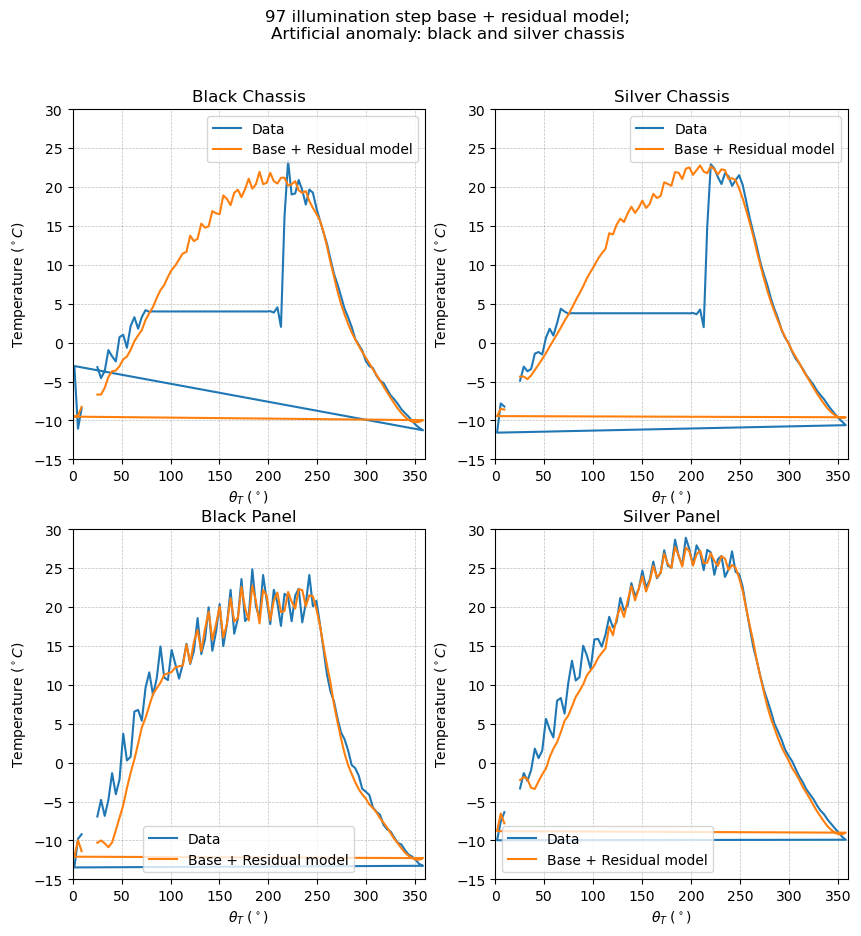

In [55]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_actual[:, 0] * (max_temp - min_temp) + min_temp,
    label="Data",
)
# plt.plot(
#     anomaly_50_windowed_df['theta_T'],
#     y_base[:98, 0],
#     label="Base model",
# )
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_res[:, 0] * (max_temp - min_temp) + min_temp,
    label="Base + Residual model",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ C$)")
plt.title("Black Chassis")
plt.legend()
plt.xlim([0, 360])
plt.ylim([-15, 30])
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_actual[:, 1] * (max_temp - min_temp) + min_temp,
    label="Data",
)
# plt.plot(
#     anomaly_50_windowed_df['theta_T'],
#     y_base[:98, 1],
#     label="Base model",
# )
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_res[:, 1] * (max_temp - min_temp) + min_temp,
    label="Base + Residual model",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ C$)")
plt.title("Silver Chassis")
plt.legend()
plt.xlim([0, 360])
plt.ylim([-15, 30])
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_actual[:, 2] * (max_temp - min_temp) + min_temp,
    label="Data",
)
# plt.plot(
#     anomaly_50_windowed_df['theta_T'],
#     y_base[:98, 2],
#     label="Base model",
# )
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_res[:, 2] * (max_temp - min_temp) + min_temp,
    label="Base + Residual model",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ C$)")
plt.title("Black Panel")
plt.legend()
plt.xlim([0, 360])
plt.ylim([-15, 30])
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_actual[:, 3] * (max_temp - min_temp) + min_temp,
    label="Data",
)
# plt.plot(
#     anomaly_50_windowed_df['theta_T'],
#     y_base[:98, 3],
#     label="Base model",
# )
plt.plot(
    anomaly_50_windowed_df['theta_T'],
    y_res[:, 3] * (max_temp - min_temp) + min_temp,
    label="Base + Residual model",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ C$)")
plt.title("Silver Panel")
plt.xlim([0, 360])
plt.ylim([-15, 30])
plt.legend()
plt.grid()

plt.suptitle("97 illumination step base + residual model;\nArtificial anomaly: black and silver chassis")
plt.show()
plt.close()

# anomaly_97_df = create_artificial_anomaly(
#     window_size=97,
#     anomaly_black_chassis=True,
#     anomaly_silver_chassis=True,
# )

# anomaly_50_windowed_df['theta_T'], anomaly_50_x, anomaly_50_y = window_data_v4(anomaly_97_df, 97, model_97, return_numpy=True, check_continuity=False)

# y_pred_anomaly = model_97_res_3.predict(anomaly_50_x)

# plot_model(
#     anomaly_50_windowed_df['theta_T']["theta_T"],
#     anomaly_50_y + anomaly_50_x[:, -1, 1:],
#     y_pred_anomaly + anomaly_50_x[:, -1, 1:],
#     limit_axis=False
# )

In [73]:
def window_data_v5(df, window_size, base_model, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["prev black chassis temp " + str(i) for i in range(10)],
        ["prev silver chassis temp " + str(i) for i in range(10)],
        ["prev black panel temp " + str(i) for i in range(10)],
        ["prev silver panel temp " + str(i) for i in range(10)],       
        ["black chassis temp prediction"],
        ["silver chassis temp prediction"],
        ["black panel temp prediction"],
        ["silver panel temp prediction"],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))
    with alive_bar(total=len(window_df), theme='classic', force_tty=True) as bar:
        for i in range(len(window_df)):
            if check_continuity:
                if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                    bar()
                    continue
            
            window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
            window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
            if i<15:
                bar()
                continue
            for j in range(10):
                window_df.loc[i, "prev black chassis temp " + str(j)] = df.loc[i - j - 1, "black chassis temperature (deg C)"]
                window_df.loc[i, "prev silver chassis temp " + str(j)] = df.loc[i - j - 1, "silver chassis temperature (deg C)"]
                window_df.loc[i, "prev black panel temp " + str(j)] = df.loc[i - j - 1, "black panel temperature (deg C)"]
                window_df.loc[i, "prev silver panel temp " + str(j)] = df.loc[i - j - 1, "silver panel temperature (deg C)"]


            # window_df.loc[i, "prev black chassis temp 0"] = df.loc[i - 3, "black chassis temperature (deg C)"]
            # window_df.loc[i, "prev silver chassis temp 0"] = df.loc[i - 3, "silver chassis temperature (deg C)"]
            # window_df.loc[i, "prev black panel temp 0"] = df.loc[i - 3, "black panel temperature (deg C)"]
            # window_df.loc[i, "prev silver panel temp 0"] = df.loc[i - 3, "silver panel temperature (deg C)"]
            # window_df.loc[i, "prev black chassis temp 1"] = df.loc[i - 2, "black chassis temperature (deg C)"]
            # window_df.loc[i, "prev silver chassis temp 1"] = df.loc[i - 2, "silver chassis temperature (deg C)"]
            # window_df.loc[i, "prev black panel temp 1"] = df.loc[i - 2, "black panel temperature (deg C)"]
            # window_df.loc[i, "prev silver panel temp 1"] = df.loc[i - 2, "silver panel temperature (deg C)"]
            # window_df.loc[i, "prev black chassis temp 2"] = df.loc[i - 1, "black chassis temperature (deg C)"]
            # window_df.loc[i, "prev silver chassis temp 2"] = df.loc[i - 1, "silver chassis temperature (deg C)"]
            # window_df.loc[i, "prev black panel temp 2"] = df.loc[i - 1, "black panel temperature (deg C)"]
            # window_df.loc[i, "prev silver panel temp 2"] = df.loc[i - 1, "silver panel temperature (deg C)"]

            window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
            window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
            window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]
            bar()

    window_df = window_df.dropna(how='all').reset_index(drop=True)
    x_pred = np.empty(shape=(len(window_df), window_size, 1), dtype=np.float64)
    x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    y_pred = base_model.predict(x_pred, verbose=0)
    window_df["black chassis temp prediction"] = y_pred[:, 0]
    window_df["silver chassis temp prediction"] = y_pred[:, 1]
    window_df["black panel temp prediction"] = y_pred[:, 2]
    window_df["silver panel temp prediction"] = y_pred[:, 3]
    
    
    # x_pred = np.empty(shape=(len(window_df), window_size, 1))
    # x_pred[:, :, 0] = window_df.iloc[:, 1:window_size + 1].to_numpy()
    # y_pred = base_model.predict(x_pred, verbose=1)
    # window_df["input black chassis temp"] = y_pred[:, 0]
    # window_df["input silver chassis temp"] = y_pred[:, 1]
    # window_df["input black panel temp"] = y_pred[:, 2]
    # window_df["input silver panel temp"] = y_pred[:, 3]
    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), window_size, 4), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.loc["prev black chassis temp 0":"prev black chassis temp 9"].to_numpy()
            x_data[i, :, 1] = row.loc["prev silver chassis temp 0":"prev silver chassis temp 9"].to_numpy()
            x_data[i, :, 2] = row.loc["prev black panel temp 0":"prev black panel temp 9"].to_numpy()
            x_data[i, :, 3] = row.loc["prev silver panel temp 0":"prev silver panel temp 9"].to_numpy()
            x_data[i, 0, 1] = row.loc["prev silver chassis temp 2"]
            x_data[i, 0, 2] = row.loc["prev black panel temp 2"]
            x_data[i, 0, 3] = row.loc["prev silver panel temp 2"]
            y_data[i, 0] = row.loc["black chassis temp"] - row.loc["black chassis temp prediction"] + 0.5
            y_data[i, 1] = row.loc["silver chassis temp"] - row.loc["silver chassis temp prediction"] + 0.5
            y_data[i, 2] = row.loc["black panel temp"] - row.loc["black panel temp prediction"] + 0.5
            y_data[i, 3] = row.loc["silver panel temp"] - row.loc["silver panel temp prediction"] + 0.5

        return window_df, x_data, y_data

    return window_df

In [74]:
train_97_res_df_4, x_train_97_res_4, y_train_97_res_4 = window_data_v5(train_norm_df, 97, model_97, return_numpy=True)
test_97_red_df_4, x_test_97_res_4, y_test_97_res_4 = window_data_v5(test_norm_df, 97, model_97, return_numpy=True)


[========================================] 835/835 [100%] in 2.6s (315.61/s)                                            
[========================================] 137/137 [100%] in 0.8s (162.44/s)                                            


Epoch 1/200
11/11 [==============================] - 23s 524ms/step - loss: 0.2402 - mean_absolute_error: 0.4891 - val_loss: 0.2408 - val_mean_absolute_error: 0.4898
Epoch 2/200
11/11 [==============================] - 1s 49ms/step - loss: 0.2283 - mean_absolute_error: 0.4767 - val_loss: 0.2271 - val_mean_absolute_error: 0.4755
Epoch 3/200
11/11 [==============================] - 1s 50ms/step - loss: 0.2122 - mean_absolute_error: 0.4594 - val_loss: 0.2071 - val_mean_absolute_error: 0.4537
Epoch 4/200
11/11 [==============================] - 1s 50ms/step - loss: 0.1877 - mean_absolute_error: 0.4312 - val_loss: 0.1745 - val_mean_absolute_error: 0.4149
Epoch 5/200
11/11 [==============================] - 1s 49ms/step - loss: 0.1478 - mean_absolute_error: 0.3791 - val_loss: 0.1220 - val_mean_absolute_error: 0.3401
Epoch 6/200
11/11 [==============================] - 1s 48ms/step - loss: 0.0894 - mean_absolute_error: 0.2801 - val_loss: 0.0600 - val_mean_absolute_error: 0.2192
Epoch 7/200
11

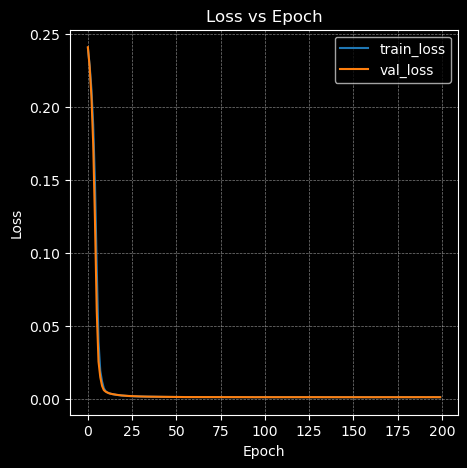

In [76]:

model_97_res_4, recommended_device = create_model(
    model_97_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    [tf.keras.metrics.MeanAbsoluteError()],
    input_shape=(None, 4)
)


with tf.device("/GPU:0"):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True
    )

    history_97_res_4 = model_97_res_4.fit(
        x_train_97_res_4,
        y_train_97_res_4,
        epochs=150,
        validation_data=(x_test_97_res_4, y_test_97_res_4),

    )

plt.figure(figsize=(5, 5))
plt.plot(history_97_res_4.history["loss"], label="train_loss", color=plt_colors[0])
plt.plot(history_97_res_4.history["val_loss"], label="val_loss", color=plt_colors[1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.legend()
plt.show()

4/4 [==============================] - 0s 69ms/step


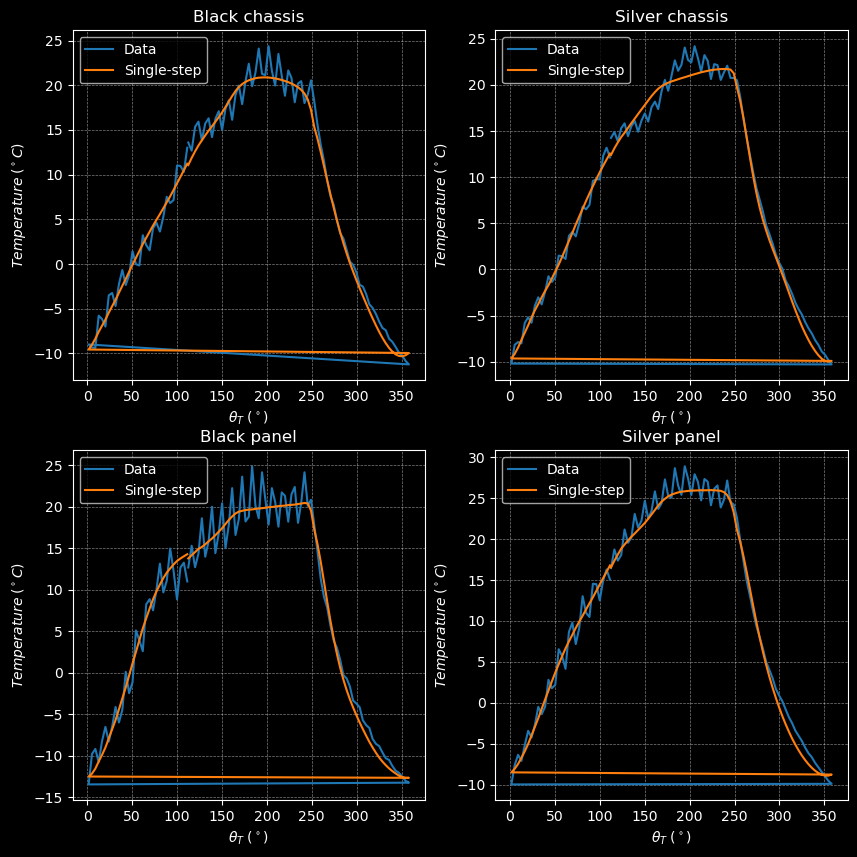

In [77]:
y_pred_res_4 = model_97_res_4.predict(x_test_97_res_4)
y_pred_base = model_97.predict(x_test_97)

plot_model(
    test_97_red_df_4["theta_T"][:98],
    (y_test_97_res_4[:98] + y_pred_base[:98] - 0.5) * (max_temp - min_temp) + min_temp,
    (y_pred_res_4[:98] + y_pred_base[:98] - 0.5) * (max_temp - min_temp) + min_temp,
    limit_axis=False
)


# # Calculating the mean absolute error for the prediction

# y_actual = test_97_red_df_4.loc[:97, "black chassis temp":"silver panel temp"].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp
# y_predicted = y_pred_res_4[:98] + y_pred_base[:98] * (max_temp - min_temp) + min_temp

# mae = np.mean(np.abs(y_actual - y_predicted), axis=0)
# print(f"Mean absolute errors (per channel): {mae} \nMean absolute error (overall): {np.mean(mae)}")


# anomaly_50_windowed_df, anomaly_50_x, anomaly_50_y = window_data_v5(anomaly_97_df, 97, model_97, return_numpy=True, check_continuity=False)

# y_pred_anomaly = model_97_res_4.predict(anomaly_50_x)
# y_pred_base = model_97.predict(anomaly_50_x[:, :, 0:1])

# plot_model(
#     anomaly_50_windowed_df["theta_T"],
#     (anomaly_50_y + y_pred_base) * (max_temp - min_temp) + min_temp,
#     (y_pred_anomaly + y_pred_base) * (max_temp - min_temp) + min_temp,
#     limit_axis=False
# )



In [61]:
train_50_df_2, x_train_50_2, y_train_50_2 = window_data_v2(train_norm_df, 50, return_numpy=True)
test_50_df_2, x_test_50_2, y_test_50_2 = window_data_v2(test_norm_df, 50, return_numpy=True)


TypeError: window_data_v2() missing 1 required positional argument: 'base_model'

In [ ]:

model_50_2, recommended_device = create_model(
    model_50_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 5),
)

model_50_2.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_50 = model_50_2.fit(
        x_train_50_2,
        y_train_50_2,
        epochs=200,
        validation_data=(x_test_50_2, y_test_50_2),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_50.history["loss"]), len(history_50.history["loss"])),
    history_50.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_50.history["loss"]), len(history_50.history["loss"])),
    history_50.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
def test_solar_inputs_2(model, percent_change, x_data, y_data, theta_T):
    reduced_x = x_data.copy()
    increased_x = x_data.copy()
    reduced_x[:, :, 0] = x_data[:, :, 0] * (1 - percent_change)
    increased_x[:, :, 0] = x_data[:, :, 0] * (1 + percent_change)

    reduced_y_pred = model.predict(reduced_x, verbose=False)
    increased_y_pred = model.predict(increased_x, verbose=False)

    reduced_y_pred = reduced_y_pred + x_data[:, -1, 1:]
    increased_y_pred = increased_y_pred + x_data[:, -1, 1:]

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(
        theta_T,
        y_data[:, 0] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 0] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 0] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Black chassis")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(
        theta_T,
        y_data[:, 1] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 1] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 1] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Silver chassis")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.plot(
        theta_T,
        y_data[:, 2] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 2] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 2] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Black panel")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(
        theta_T,
        y_data[:, 3] * (max_temp - min_temp) + min_temp,
        label="Actual",
        color=plt_colors[0],
    )
    plt.plot(
        theta_T,
        reduced_y_pred[:, 3] * (max_temp - min_temp) + min_temp,
        label="Reduced",
        color=plt_colors[1],
        linestyle="dashed",
        linewidth=2,
    )
    plt.plot(
        theta_T,
        increased_y_pred[:, 3] * (max_temp - min_temp) + min_temp,
        label="Increased",
        color=plt_colors[2],
        linestyle="dashed",
        linewidth=2,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel("Temperature (deg C)")
    plt.title("Silver panel")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
y_pred_50_2 = model_50_2.predict(x_test_50_2, verbose=0)

y_actual = y_test_50_2 + x_test_50_2[:, -1, 1:]
y_pred = y_pred_50_2 + x_test_50_2[:, -1, 1:]
plot_model(
    test_50_df["theta_T"][18:115],
    y_actual[18:115] * (max_temp - min_temp) + min_temp,
    y_pred[18:115] * (max_temp - min_temp) + min_temp,
    plt_title="50-setp window, no anomaly",
    limit_axis=False,
)

test_solar_inputs_2(
    model_50_2,
    0.2,
    x_test_50_2[18:115],
    y_actual[18:115],
    test_50_df["theta_T"][18:115],
)

In [ ]:
x_test_50_3 = x_test_50_2.copy()
x_test_50_3[:, :, 0] = x_test_50_2[:, :, 0] * 0.9

y_pred_50_2 = model_50_2.predict(x_test_50_3, verbose=0)

y_actual = y_test_50_2 + x_test_50_3[:, -1, 1:]
y_pred = y_pred_50_2 + x_test_50_3[:, -1, 1:]
plot_model(
    test_50_df["theta_T"][18:115],
    y_actual[18:115] * (max_temp - min_temp) + min_temp,
    y_pred[18:115] * (max_temp - min_temp) + min_temp,
    plt_title="50-setp window, no anomaly",
    limit_axis=False,
)

In [ ]:
anomaly_50_windowed_df_2, x_anomaly_50_windowed_2, y_anomaly_50_windowed_2 = window_data_v2(anomaly_50_df, 50, return_numpy=True, check_continuity=False)

y_pred_anomaly_50_2 = model_50_2.predict(x_anomaly_50_windowed_2, verbose=0)

y_actual_anomaly = y_anomaly_50_windowed_2 + x_anomaly_50_windowed_2[:, -1, 1:]
y_pred_anomaly = y_pred_anomaly_50_2 + x_anomaly_50_windowed_2[:, -1, 1:]

plot_model(
    anomaly_50_windowed_df_2["theta_T"],
    y_actual_anomaly * (max_temp - min_temp) + min_temp,
    y_pred_anomaly * (max_temp - min_temp) + min_temp,
    plt_title="50-setp window, anomaly",
    limit_axis=False,
)

In [ ]:
model_50_layers = np.empty(shape=(7), dtype=dict,)
model_50_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_50_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_50_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_50_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_50_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_50_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_50_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

In [ ]:
model_50, recommended_device = create_model(
    model_50_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

# Get the initial weights
initial_weights_0 = model_50.get_weights()

In [ ]:
model_50, recommended_device = create_model(
    model_50_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

# Get the initial weights
initial_weights_1 = model_50.get_weights()

In [ ]:
print(initial_weights_0[0])
print(initial_weights_1[0])

In [ ]:
def test_func():
    tf.random.set_seed(42)
    model_50, recommended_device = create_model(
        model_50_layers,
        tf.keras.optimizers.Adam(learning_rate=5e-5),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
    )

    model_50_1, recommended_device = create_model(
        model_50_layers,
        tf.keras.optimizers.Adam(learning_rate=5e-5),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
    )

    return model_50, model_50_1

In [ ]:
a, b = test_func()

print(a.get_weights()[0])
print(b.get_weights()[0])